In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [ ]:
img=cv2.imread('/content/Image1.png', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [ ]:
img.shape

(493, 565, 3)

In [ ]:
Io = 240
alpha = 1
beta = 0.15

In [ ]:
HERef = np.array([[0.5626, 0.2159],
                  [0.7201, 0.8012],
                  [0.4062, 0.5581]])

In [ ]:
maxCRef = np.array([1.9705, 1.0308])

In [ ]:
h, w, c = img.shape

In [ ]:
img = img.reshape((-1,3))

In [ ]:
OD = -np.log10((img.astype(np.float)+1)/Io)

<ipython-input-184-0fca81780ebd> (1): `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


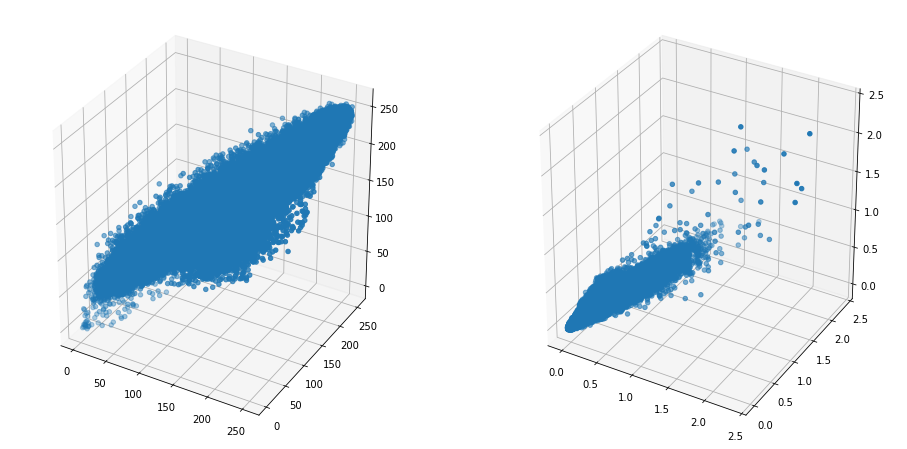

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(img[:,0],img[:,1],img[:,2])
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(OD[:,0],OD[:,1],OD[:,2])
plt.show()

In [ ]:
ODhat = OD[~np.any(OD < beta, axis=1)]

In [ ]:
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

In [ ]:
That = ODhat.dot(eigvecs[:,1:3])

In [ ]:
phi = np.arctan2(That[:,1],That[:,0])

minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


In [ ]:
if vMin[0] > vMax[0]:
    HE = np.array((vMin[:,0], vMax[:,0])).T

else:
    HE = np.array((vMax[:,0], vMin[:,0]))

In [ ]:
Y = np.reshape(OD, (-1, 3)).T


C = np.linalg.lstsq(HE,Y, rcond=None)[0]


maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])



Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm[Inorm>255] = 254
Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

In [ ]:
H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

plt.imsave("/content/Images/HnE_normalized.jpg", Inorm)
plt.imsave("/content/Images/HnE_separated_H.jpg", H)
plt.imsave("/content/Images/HnE_separated_E.jpg", E)

In [ ]:
!pip install stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [ ]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [ ]:
from skimage import io

In [ ]:
HE_img = io.imread("/content/Images/HnE_separated_H.jpg")


In [ ]:
HE_model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [ ]:

he_labels, _ = HE_model.predict_instances(normalize(HE_img))

1/1 [==============================] - 0s 199ms/step


In [ ]:

plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1)
plt.imshow(HE_img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(he_labels)
plt.axis("off")
plt.title("prediction")

Text(0.5, 1.0, 'prediction')

In [ ]:
!pip install pyclesperanto_prototype

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyclesperanto_prototype as cle

In [ ]:
device = cle.select_device('RTX')
print("Used GPU: ", device)

input_image = np.invert(H[:,:,2])
plt.imshow(input_image, cmap='gray')
#Before segmenting the image, need to push it to GPU memory. For visualisation purposes we crop out a sub-region:
input_gpu = cle.push(input_image)


cle.imshow(input_gpu)

sigma_spot_detection = 3
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection,
                                      outline_sigma=sigma_outline)

cle.imshow(segmented, labels=True)


statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented)

import pandas as pd
table = pd.DataFrame(statistics)

print(table.describe())
print(table.info())

Used GPU:  <Tesla T4 on Platform: NVIDIA CUDA (2 refs)>


            label  original_label  bbox_min_x  bbox_min_y  bbox_min_z  \
count  835.000000      835.000000  835.000000  835.000000       835.0   
mean   418.000000      418.000000  261.943726  244.585632         0.0   
std    241.188032      241.188032  173.513824  141.693985         0.0   
min      1.000000        1.000000    0.000000    0.000000         0.0   
25%    209.500000      209.500000  101.500000  127.500000         0.0   
50%    418.000000      418.000000  255.000000  246.000000         0.0   
75%    626.500000      626.500000  418.500000  363.500000         0.0   
max    835.000000      835.000000  564.000000  492.000000         0.0   

       bbox_max_x  bbox_max_y  bbox_max_z  bbox_width  bbox_height  ...  \
count  835.000000  835.000000       835.0  835.000000   835.000000  ...   
mean   271.972443  256.285034         0.0   11.028743    12.699401  ...   
std    173.734344  141.818161         0.0    4.141865     4.650823  ...   
min      0.000000    1.000000         0.0 

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

In [ ]:
img1 = cv2.imread("/content/Images/HnE_separated_H.jpg")
#img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
import numpy as np
import cv2

In [ ]:
img = cv2.imread("/content/Images/HnE_separated_H.jpg")

img2 = img.reshape((-1,3))

from sklearn.mixture import GaussianMixture as GMM


gmm_model = GMM(n_components=2, covariance_type='tied').fit(img2)
gmm_labels = gmm_model.predict(img2)


original_shape = img.shape
segmented = gmm_labels.reshape(original_shape[0], original_shape[1])
cv2.imwrite("/content/Images/segmented.jpg", segmented)

True

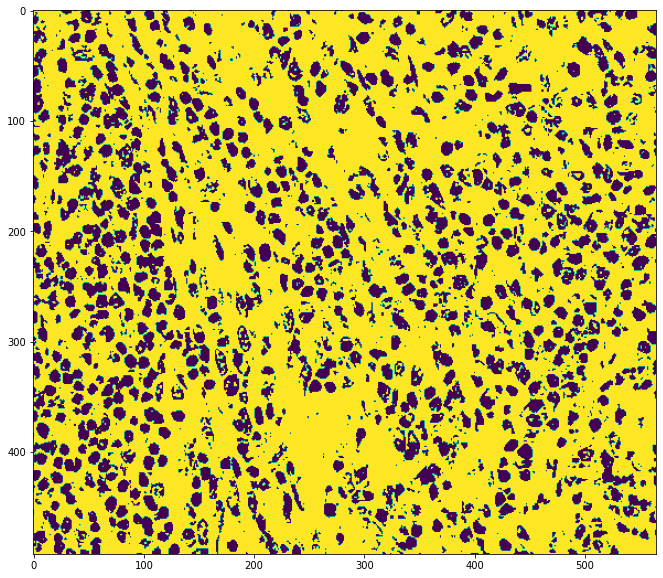

In [ ]:
plt.imshow(segmented)

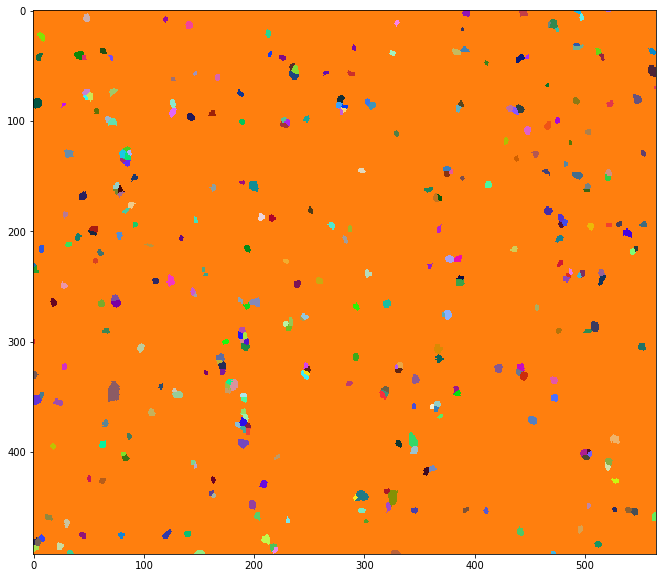

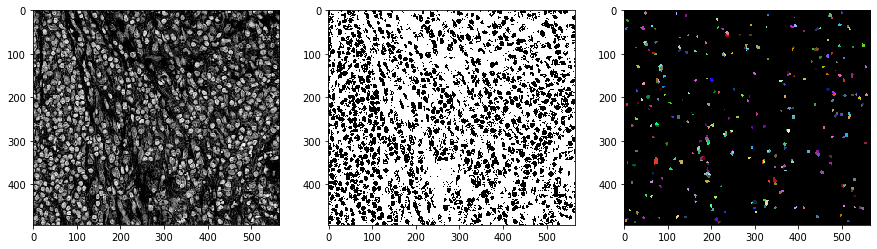

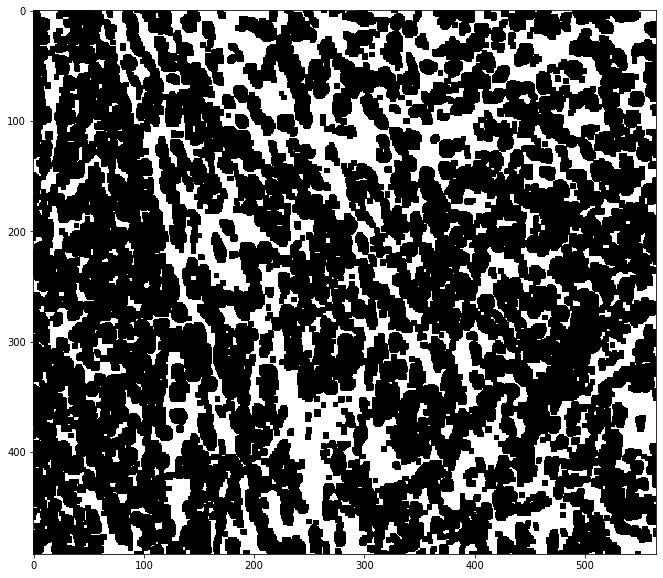

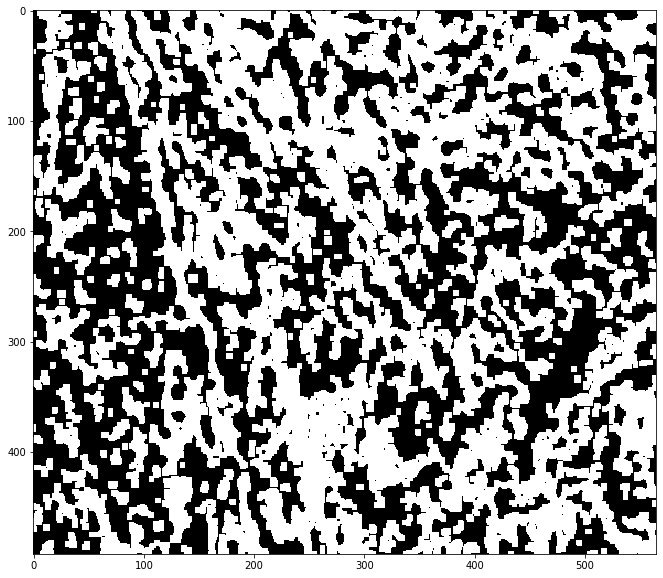

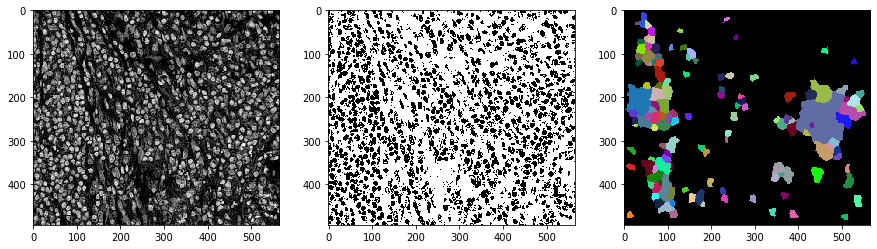

Total objects detected are:  132.0


<ipython-input-210-83359d3ab117> (93): labeled_image.tif is a low contrast image


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   label                                   132 non-null    int64  
 1   original_label                          132 non-null    int64  
 2   bbox_min_x                              132 non-null    float32
 3   bbox_min_y                              132 non-null    float32
 4   bbox_min_z                              132 non-null    float32
 5   bbox_max_x                              132 non-null    float32
 6   bbox_max_y                              132 non-null    float32
 7   bbox_max_z                              132 non-null    float32
 8   bbox_width                              132 non-null    float32
 9   bbox_height                             132 non-null    float32
 10  bbox_depth                              132 non-null    float3

_imshow.py (46): The imshow parameter color_map is deprecated. Use colormap instead.


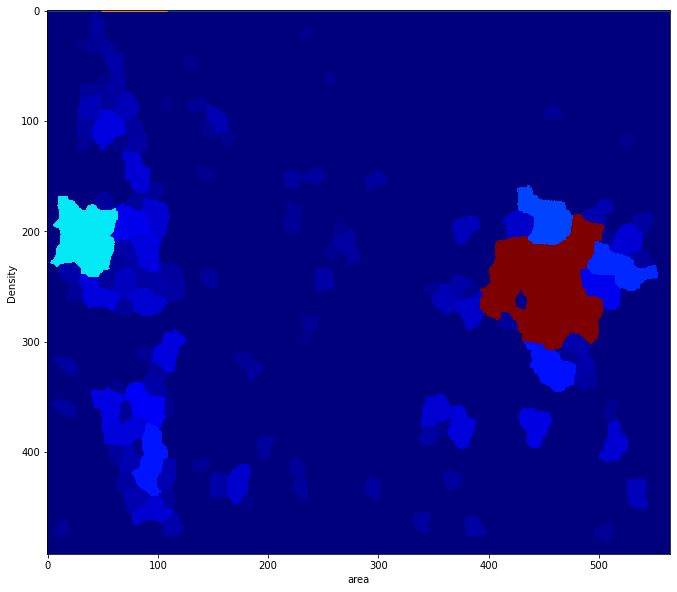

_imshow.py (46): The imshow parameter color_map is deprecated. Use colormap instead.


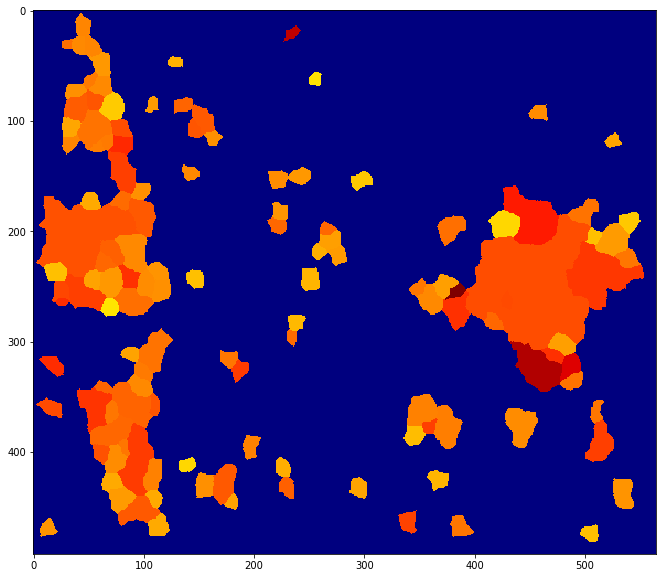

In [ ]:
from skimage import img_as_ubyte, io
import matplotlib.pyplot as plt
import numpy as np
import pyclesperanto_prototype as cle

input_image_original = img_as_ubyte(io.imread("/content/Images/HnE_separated_H.jpg", as_gray=True))
input_image = np.invert(input_image_original)
binary = cle.binary_not(cle.threshold_otsu(input_image))
labels = cle.voronoi_labeling(binary)
cle.imshow(labels, labels=True)



########LET US HAVE A CLOSER LOOK############

from skimage import img_as_ubyte, io
import matplotlib.pyplot as plt
import numpy as np

input_image_original = img_as_ubyte(io.imread("/content/Images/HnE_separated_H.jpg", as_gray=True))
plt.imshow(input_image_original, cmap='gray')

input_image = np.invert(input_image_original)
plt.imshow(input_image, cmap='gray')

import pyclesperanto_prototype as cle

#Leverage GPU, if you have one
# select a specific OpenCL / GPU device and see which one was chosen
cle.select_device('RTX')
input_gpu = cle.push(input_image)


##########################################
#Straightforward segmentation without any processing

#Binarize (Thresholding using otsu)
binary = cle.binary_not(cle.threshold_otsu(input_gpu))
cle.imshow(binary)

#Use voronoi labeling method to generate labels
labels = cle.voronoi_labeling(binary)

#Visualize
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(input_gpu, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(labels, plot=axs[2], labels=True)

#If we do not want to include the edge touching grains...
labeled_excl_edges = cle.exclude_labels_on_edges(labels)
cle.imshow(labeled_excl_edges, labels=True)

####################
#Segmentation with some image processing e.g., erosion, dilation

binary = cle.binary_not(cle.threshold_otsu(input_gpu))
cle.imshow(binary)

# binary closing: dilation (minimum) followed by erosion (maximum)
binary_dilated = cle.minimum_box(binary, radius_x=2, radius_y=2)
cle.imshow(binary_dilated)

binary_eroded = cle.maximum_box(binary_dilated, radius_x=2, radius_y=2)
cle.imshow(binary_eroded)

#Generate labels
labels = cle.voronoi_labeling(binary_eroded)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(input_gpu, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(labels, plot=axs[2], labels=True)

#If we do not want to include the edge touching grains...
labeled_excl_edges = cle.exclude_labels_on_edges(labels)
cle.imshow(labeled_excl_edges, labels=True)


#######################################################
# Number of objects segmented?
#This will be the maximum label assigned to an object 9as each object is assigned unique label value)
num_objects = cle.maximum_of_all_pixels(labeled_excl_edges)
print("Total objects detected are: ", num_objects)

#Save segmented/labeled image to disk
# save image to disc
from skimage.io import imsave
labeled_array = cle.pull(labeled_excl_edges)
#This is a uint32 labeled image with each object given an integer value.
plt.imshow(labeled_array)

imsave("labeled_image.tif", labeled_array)  #Open in imageJ for better visualization

#################################

#Extract statistics and plotting using seaborn / matplotlib
statistics = cle.statistics_of_labelled_pixels(input_gpu, labeled_excl_edges)

import pandas as pd
stats_table = pd.DataFrame(statistics)
print(stats_table.info())

import seaborn as sns
sns.kdeplot(stats_table['area'], shade=True)

sns.kdeplot(stats_table['mean_intensity'], shade=True)

#Map by grain size (pixel count)
pixel_count_map = cle.label_pixel_count_map(labeled_excl_edges)
cle.imshow(pixel_count_map, color_map='jet')

#Extension ratio map
#The extension ratio is a shape descriptor derived from the maximum distance
# of pixels to their object's centroid divided by the average distance of
#pixels to the centroid.
extension_ratio_map = cle.extension_ratio_map(labeled_excl_edges)
cle.imshow(extension_ratio_map, color_map='jet')